In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

import itertools

In [4]:
def load_basic_params():
    fov_list = [201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 228, 229]
    r = 10
    c = 2

    return fov_list, r, c

def load_barcodes(r,c):
    # only add background to the df
    df_barcodes = pd.read_csv('/data/Spots_barcode_Emily/dataset_2/barcodes.csv', index_col=0)
    df_barcodes.drop('id', axis=1, inplace=True)
    df_barcodes.index.name = 'code_name'
    df_barcodes = df_barcodes.reset_index()
    df_barcodes.index += 1
    df_barcodes.loc[266] = ['Background'] + [0]*20
    df_barcodes.loc[267] = ['Unknown'] + [-1]*20
    barcodes_idx2name = dict(zip(1+np.arange(len(df_barcodes)), df_barcodes.code_name.values))
    ch_names = list(df_barcodes.columns)
    ch_names.remove('code_name')
    barcodes_array = df_barcodes[ch_names].values.reshape(-1,r,c)[:-2, :,:] # only the valid & blank genes
    return df_barcodes, ch_names, barcodes_idx2name, barcodes_array

In [9]:
def generate_fov_location_list():
    fov_location_list = np.array([[[0, 0],  [0, 1],  [0, 2],  [0, 3],  [0, 4],  [0, 5],  [0, 6],  [0, 7],  [0, 8],  [0, 9],  [0, 10]], 
             [[1, 10],  [1, 9],  [1, 8],  [1, 7],  [1, 6],  [1, 5],  [1, 4],  [1, 3],  [1, 2],  [1, 1],  [1, 0]],
             [[2, 0],  [2, 1],  [2, 2],  [2, 3],  [2, 4],  [2, 5],  [2, 6],  [2, 7],  [2, 8],  [2, 9],  [2, 10]]])
    return fov_location_list

fov_location_list = generate_fov_location_list()

In [5]:
df_orig = pd.read_csv('/data/Spots_barcode_Emily/dataset_5/output_expr_comparison/original_postcode_old/decoded_spots_all_fovs_trunc.csv', index_col=0)
df_new = pd.read_csv('/data/Spots_barcode_Emily/dataset_2/output_expr_comparison/relaxed_bernoulli_2*R*C/decoded_spots_all_fovs_clip99.9_thres0.85_trunc.csv', index_col=0)
disagree_mask = df_orig.predicted_id != df_new.predicted_id

In [6]:
fov_list, r, c = load_basic_params()
df_barcodes, ch_names, barcodes_idx2name, barcodes_array = load_barcodes(r,c)


In [10]:
df_new.loc[:, 'mask_x'] = df_new.x >984
df_new.loc[:, 'mask_y'] = df_new.y >984

df_new[['mask_x', 'mask_y']] = df_new[['mask_x', 'mask_y']].astype(int)
df_big = pd.concat([df_new, df_orig[['predicted_id']].rename(columns={'predicted_id':'predicted_id_orig'})], axis=1)


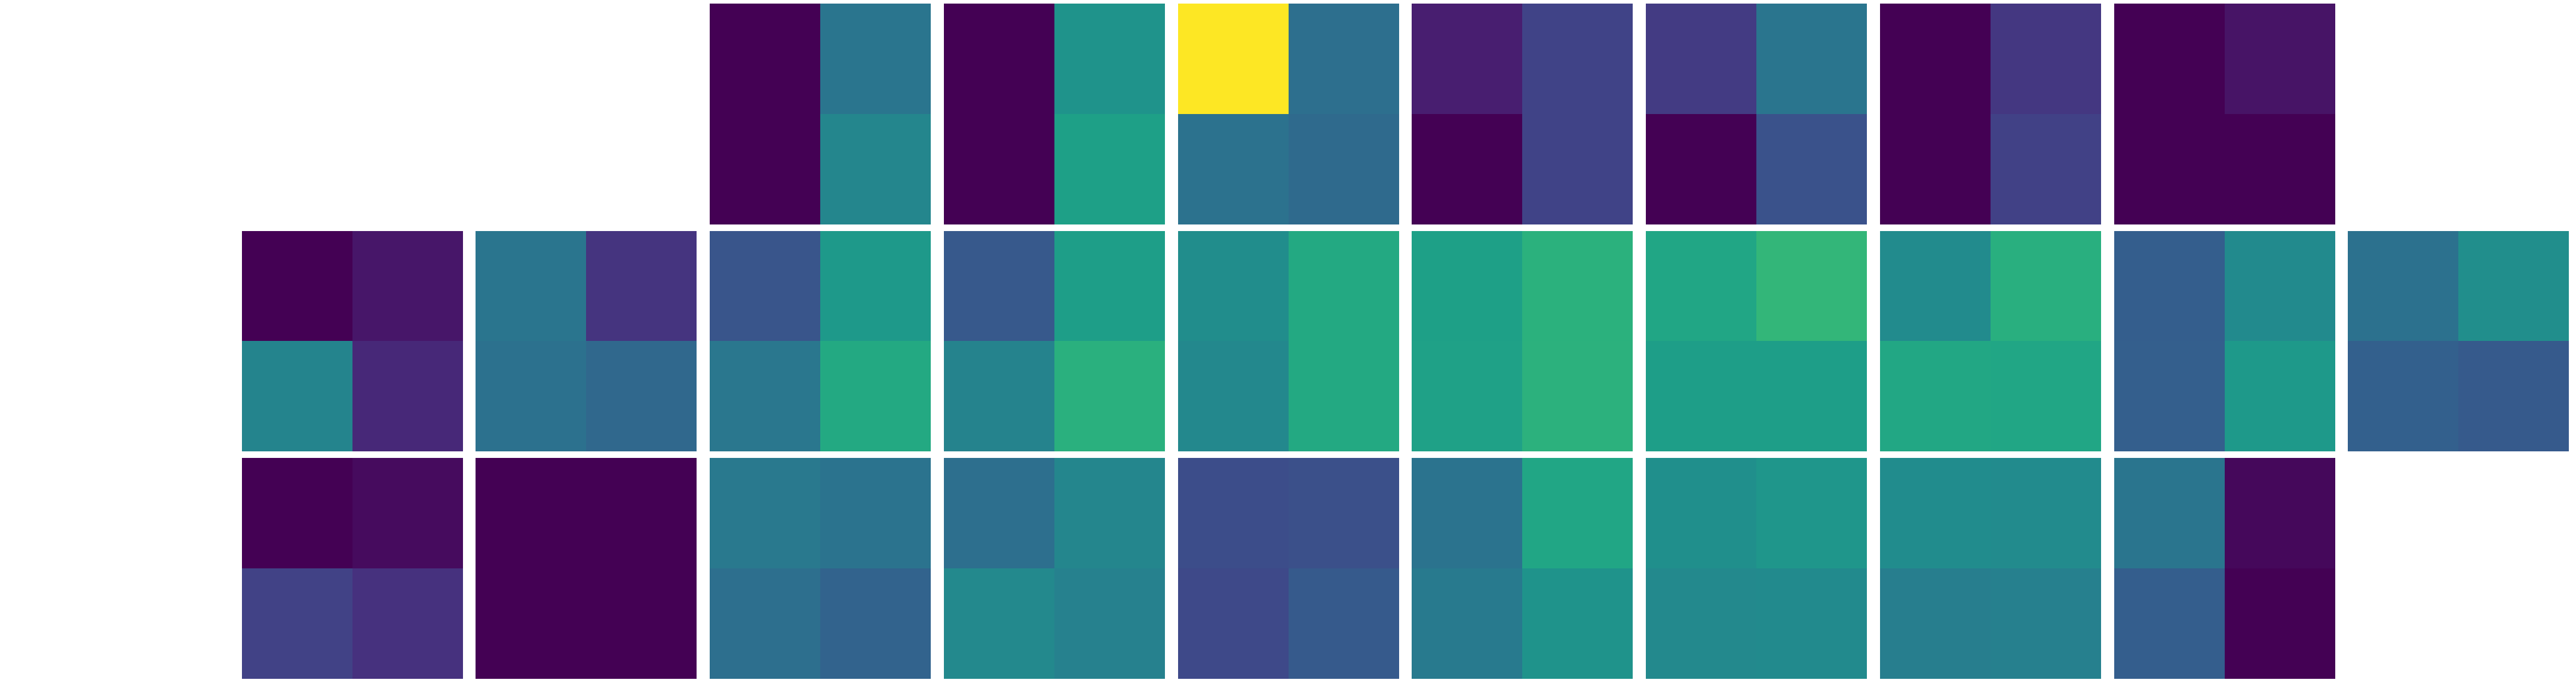

In [11]:
fig, ax = plt.subplots(3,11)
fig.set_size_inches(60,16)
for idx_fov, (idx_ax_x, idx_ax_y) in zip(np.arange(198,231), fov_location_list.reshape(-1,2)):
    if idx_fov in fov_list:
        df_big_subset = df_big[(df_new.z==4) & (df_new.fov_id==idx_fov)]
        
        f1_table = np.zeros((2,2))
        for idx, subdf in df_big_subset.groupby(['mask_x', 'mask_y']):
            f1_table[idx] = f1_score(subdf.predicted_id.values, subdf.predicted_id_orig.values, average='weighted')
        
        img = ax[idx_ax_x, idx_ax_y].imshow(f1_table)
        img.set_clim([0.1,0.9])
    
    ax[idx_ax_x, idx_ax_y].axis('off')
    
fig.tight_layout()